# **ML Lifecycle**
### This notebook combines the analysis, cleaning, preprocessing, visualization, pipeline generation and model training process into functions that can be used for different datasets

#### Dataset features must include - "text", "label"

In [477]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score, StratifiedKFold



In [53]:
df = pd.read_csv('../csv/oversampled_data.csv')
df.sample(3)

,label,text,priority,urgency,type,queue
1700,0,Form labels missing association with inputs fo...,low,not_urgent,NaN,NaN
3146,0,NPD idea approval process lacks necessary deta...,low,not_urgent,NaN,NaN
7775,0,Urgent: Cisco Router ISR4331 Network Connectio...,medium,not_urgent,Problem,Technical Support


## Analysis

In [54]:
def analysis(df):
    print(f'Shape : {df.shape}\n')
    print(f'Columns : {df.columns}\n')
    print(f"Sample: \n{df.sample(3)}\n")
    print(f"Null values: \n{df.isnull().sum()}\n")

analysis(df)

Shape : (11904, 6)

Columns : Index(['label', 'text', 'priority', 'urgency', 'type', 'queue'], dtype='object')

Sample: 
       label                                               text priority  \
10022      1  Alert: Top Priority. This is a kpi at risk mat...     high   
11628      1  Clock in immediately. High-Impact. Please hand...     high   
11496      1  Address This Quickly. High Stakes. Please hand...     high   

      urgency type queue  
10022  urgent  NaN   NaN  
11628  urgent  NaN   NaN  
11496  urgent  NaN   NaN  

Null values: 
label           0
text            0
priority        0
urgency         0
type        10348
queue       10348
dtype: int64



## Cleaning

In [55]:
def clean_data(df):
    df = df[['text', 'priority', 'urgency', 'label']]
    # df = df.rename(columns={'processed_text': 'text'})
    # df['priority'] = df['priority'].apply(lambda x: x.lower())
    # df['label'] = df['urgency'].apply(lambda x: 1 if x == 'urgent' else 0)
    return df 

df = clean_data(df)
df.sample(3)

,text,priority,urgency,label
315,There is an urgent need to correct the payment...,high,urgent,1
7721,Canon PIXMA MG3620 Exchange Request. Dear Tech...,low,not_urgent,0
10545,Attention: Bottleneck. This is a red alert mat...,high,urgent,1


## Visualization - using TF-IDF Vectorizer

In [56]:
def word_importance_chart(ax, df, title):
    tdidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
    tdidf_matrix = tdidf_vectorizer.fit_transform(df['text'])
    
    
    feature_names = tdidf_vectorizer.get_feature_names_out()
    word_scores = zip(feature_names, tdidf_matrix.sum(axis=0).tolist()[0])

    top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:10]
    
    keywords, frequencies = zip(*top_words)
    
    ax.barh(keywords, frequencies)
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Keyword')
    ax.invert_yaxis()

In [50]:
def distribution_chart(ax, df, column, title, category):
    sns.countplot(data=df, x=column, ax=ax)
    ax.set_title(title)

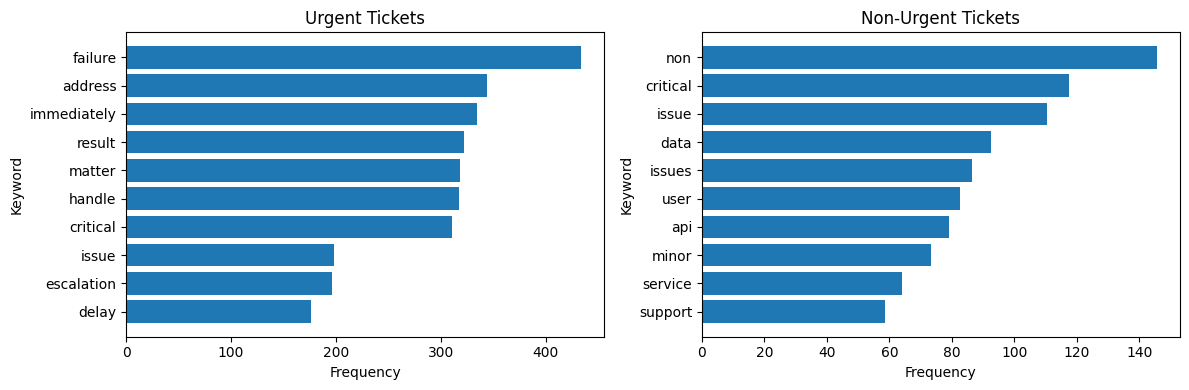

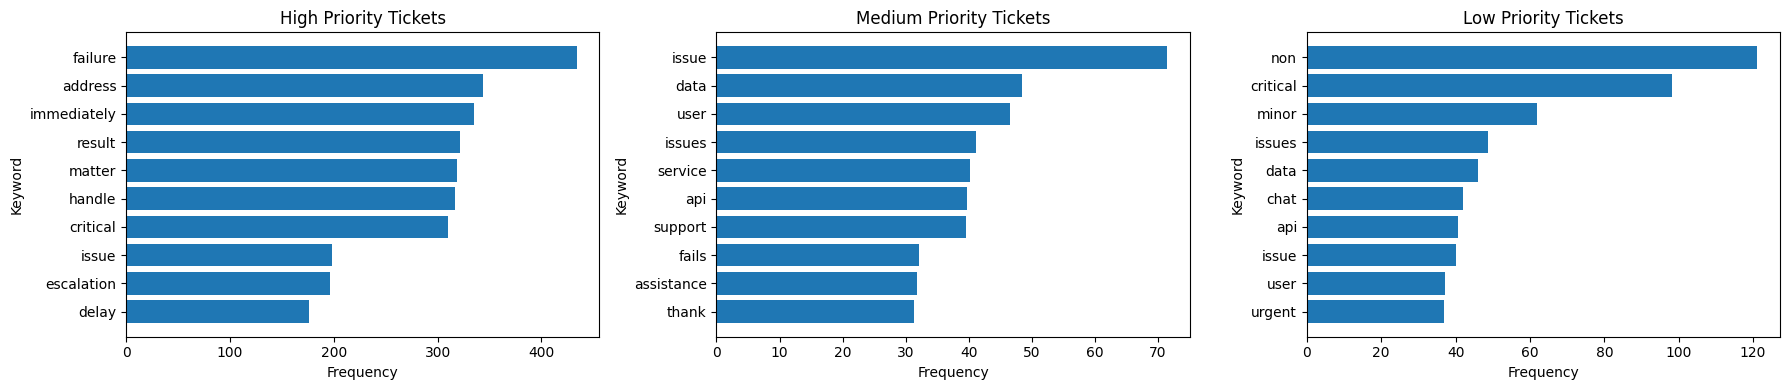

In [57]:
urgent_df = df[df['urgency'] == 'urgent']
non_urgent_df = df[df['urgency'] == 'not_urgent']

high_priority_df = df[df['priority'] == 'high']
medium_priority_df = df[df['priority'] == 'medium']
low_priority_df = df[df['priority'] == 'low']

# Urgent/Non-Urgent Tickets
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
word_importance_chart(axs[0], urgent_df, 'Urgent Tickets')
word_importance_chart(axs[1], non_urgent_df, 'Non-Urgent Tickets')
plt.tight_layout()

# Priority Tickets
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
word_importance_chart(axs[0], high_priority_df, 'High Priority Tickets')
word_importance_chart(axs[1], medium_priority_df, 'Medium Priority Tickets')
word_importance_chart(axs[2], low_priority_df, 'Low Priority Tickets')
plt.tight_layout()


urgency
urgent        6235
not_urgent    5669
Name: count, dtype: int64

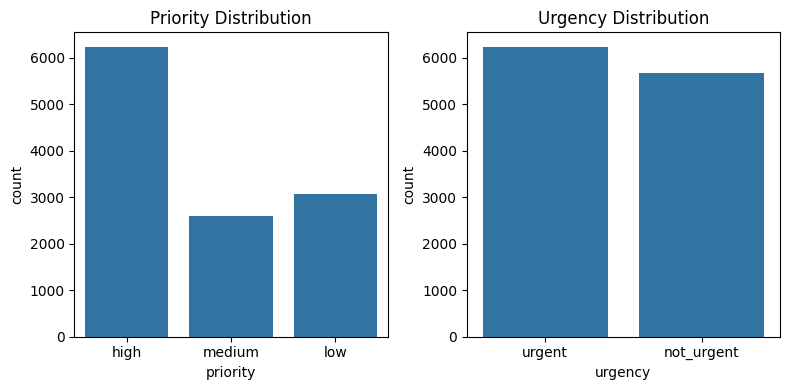

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
distribution_chart(axs[0], df, 'priority', 'Priority Distribution', 'priority')
distribution_chart(axs[1], df, 'urgency', 'Urgency Distribution', 'urgency')
plt.tight_layout()

# print number of urgent and non-urgent tickets
df['urgency'].value_counts()

### Train-Test Split function

In [59]:
def get_train_test_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

### Model Training function

In [60]:
# Training the models
def train_model(model, tdidf_vectorizer, X_train, y_train, X_test, y_test):
    text_transformer = Pipeline([
    ('tfidf', tdidf_vectorizer)
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('text_tfidf', text_transformer, 'text')
        ],
    )
    pipeline =Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"Classification Report: \n{classification_report(y_test, y_pred)}")
    return pipeline

# **Using Urgency**

## Train-Test Split 

In [61]:
X = df[['text']]
y = df['label']
X_train_urgency, X_test_urgency, y_train_urgency, y_test_urgency = get_train_test_data(X, y)

X_train shape: (9523, 1)
X_test shape: (2381, 1)


## Model Training - using Pipeline

In [62]:
# Logisitic Regression
pipeline_logreg = train_model(
    LogisticRegression(random_state=42, max_iter=1000), 
    TfidfVectorizer(),
    X_train_urgency, 
    y_train_urgency,
    X_test_urgency,
    y_test_urgency
) 

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      1117
           1       0.95      0.85      0.90      1264

    accuracy                           0.90      2381
   macro avg       0.90      0.90      0.90      2381
weighted avg       0.90      0.90      0.90      2381



In [42]:
# Support Vector Machine
pipeline_svm = train_model(
    SVC(random_state=42, kernel='linear', probability=True),
    TfidfVectorizer(), 
    X_train_urgency,
    y_train_urgency,
    X_test_urgency,
    y_test_urgency
)

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      1117
           1       0.95      0.87      0.91      1264

    accuracy                           0.91      2381
   macro avg       0.91      0.91      0.91      2381
weighted avg       0.91      0.91      0.91      2381



# Cross Validation using K-Fold

In [654]:

# Function to train and validate the model using K-Fold Cross-Validation
def cross_validate_model(model, tfidf_vectorizer, X, y, cv=5, scoring='precision', pipeline = None):
    if pipeline is None:
        text_transformer = Pipeline([
            ('tfidf', tfidf_vectorizer)
        ])

        preprocessor = ColumnTransformer(
            transformers=[
                ('text_tfidf', text_transformer, 'text')
            ],
        )

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
    else :
        pipeline = pipeline

    # Stratified K-Fold to maintain class distribution
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Use cross_val_score to evaluate accuracy
    scores = cross_val_score(
        pipeline, 
        X, 
        y, 
        cv=skf, 
        scoring=scoring
    )

    print(f"Cross-Validation {scoring.capitalize} Scores: {scores}")
    print(f"Mean: {np.mean(scores):.4f}")
    print(f"Standard Deviation: {np.std(scores):.4f}")

    return scores


In [116]:
# Testing accuracy
scored_svm = cross_validate_model(
    SVC(random_state=42, kernel='linear'), 
    TfidfVectorizer(),
    df[['text']], 
    df['urgency'].map({'urgent': 1, 'not_urgent': 0})
)

Cross-Validation <built-in method capitalize of str object at 0x00000222B8A62FB0> Scores: [0.93706294 0.9527972  0.93838028 0.94363792 0.93996569]
Mean: 0.9424
Standard Deviation: 0.0057


# Hyperparameter Tuning - using GridSearchCV

In [510]:
from sklearn.model_selection import GridSearchCV

def hyperparameter_tuning(model, X_train, y_train, param_grid):
    text_transformer = Pipeline([
        ('tfidf', TfidfVectorizer())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('text_tfidf', text_transformer, 'text')
        ],
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='recall',
        verbose=2
    )
    grid_search.fit(X_train, y_train)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_}")
    return grid_search.best_estimator_


In [511]:
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear'],
    'preprocessor__text_tfidf__tfidf__max_features': [None],
    'preprocessor__text_tfidf__tfidf__ngram_range': [(1, 1), (1, 2), (1,3), (1,4)],
}

In [512]:
best_model = hyperparameter_tuning(
    SVC(random_state=42),
    X_train_urgency,
    y_train_urgency,
    param_grid
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END classifier__C=0.1, classifier__kernel=linear, preprocessor__text_tfidf__tfidf__max_features=None, preprocessor__text_tfidf__tfidf__ngram_range=(1, 1); total time=   5.0s
[CV] END classifier__C=0.1, classifier__kernel=linear, preprocessor__text_tfidf__tfidf__max_features=None, preprocessor__text_tfidf__tfidf__ngram_range=(1, 1); total time=   4.7s
[CV] END classifier__C=0.1, classifier__kernel=linear, preprocessor__text_tfidf__tfidf__max_features=None, preprocessor__text_tfidf__tfidf__ngram_range=(1, 1); total time=   4.5s
[CV] END classifier__C=0.1, classifier__kernel=linear, preprocessor__text_tfidf__tfidf__max_features=None, preprocessor__text_tfidf__tfidf__ngram_range=(1, 1); total time=   4.5s
[CV] END classifier__C=0.1, classifier__kernel=linear, preprocessor__text_tfidf__tfidf__max_features=None, preprocessor__text_tfidf__tfidf__ngram_range=(1, 1); total time=   4.4s
[CV] END classifier__C=0.1, classifier__kern

### **Result** : Model best parameters are
kernel : linear

C value : 10

TF-IDF Max features : None

TF-IDF n-gram range: (1, 4)


## SVM Tuning

### Tuning using RBF kernel

In [498]:
print("Using RBF Kernel")
pipeline_best_svm_rbf =  train_model(
    SVC(gamma='scale', kernel='rbf', random_state=42),
    TfidfVectorizer(ngram_range=(1, 4)),
    X_train_urgency,
    y_train_urgency,
    X_test_urgency,
    y_test_urgency
)

Using RBF Kernel
Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      1117
           1       0.98      0.85      0.91      1264

    accuracy                           0.91      2381
   macro avg       0.92      0.92      0.91      2381
weighted avg       0.92      0.91      0.91      2381



### Tuning using Linear Kernel

In [642]:
print("Using Linear Kernel")
pipeline_best_svm_linear =  train_model(
    SVC(kernel='linear', random_state=42, probability=True),
    TfidfVectorizer(ngram_range=(1, 4)),
    X_train_urgency,
    y_train_urgency,
    X_test_urgency,
    y_test_urgency
)

Using Linear Kernel
Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1117
           1       0.96      0.89      0.92      1264

    accuracy                           0.92      2381
   macro avg       0.92      0.92      0.92      2381
weighted avg       0.92      0.92      0.92      2381



## Logistic Regression Model Tuning

In [501]:
print("Using Logistic Regression")
pipeline_best_logreg =  train_model(
    LogisticRegression(random_state=42, max_iter=1000), 
    TfidfVectorizer(ngram_range=(1, 4)),
    X_train_urgency,
    y_train_urgency,
    X_test_urgency,
    y_test_urgency
)

Using Logistic Regression
Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.96      0.90      1117
           1       0.96      0.86      0.91      1264

    accuracy                           0.91      2381
   macro avg       0.91      0.91      0.91      2381
weighted avg       0.91      0.91      0.91      2381



## Stacked Classifier

In [519]:
def create_stacked_model(models, meta_model = LogisticRegression(random_state=42, max_iter=1000)):
    stacked_model = StackingClassifier(
        estimators=models,
        final_estimator=meta_model,
    )
    
    stacked_model.fit(X_train_urgency, y_train_urgency)
    y_pred = stacked_model.predict(X_test_urgency)
    print(f"Classification Report: \n{classification_report(y_test_urgency, y_pred)}")
    return stacked_model

In [662]:

stacked_model_3 = create_stacked_model([
    ('svm', pipeline_svm),
    ('logreg_tuned', pipeline_best_logreg)
])

Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1117
           1       0.94      0.88      0.91      1264

    accuracy                           0.91      2381
   macro avg       0.91      0.91      0.91      2381
weighted avg       0.91      0.91      0.91      2381



## Testing Manually

In [651]:
def test_model(model, threshold = 0.5):
    example_text = pd.DataFrame([
        'This is an urgent issue',
        'I need help with my account right now without delay',
        'I have a question about my account',
        'I cannot access my account. Please help me',
        'I am unable to access my account. I have tried resetting my password but it is not working. I need help urgently',
        "Query regarding my account. Please help me",
        "The server is down. Please fix it as soon as possible",
        "System Issue. Need help before the end of the day",
        "Jira tickets need to be updated. Please do it as soon as possible. no hurry",
        "Not Critical. Please ensure system is up and running without any issues before the end of the day.",
        "this is a reminder to fill out your kaizen immediately by EOD",
        "What is the status of the server?",
        "I am having a headache and cannot focus on my work. I need to take a leave",
        "I need my salary for this month to be credited to my account",
        "how can i fix my PC not starting up, I have lots of work pending",
        "Can you fix this bug in the code? It is causing issues in the system",
         "i am having payment issue with my card." 

        ],
    columns=['text'])
    
    true_labels = [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0]

    y_scores = model.predict_proba(example_text[['text']])[:, 1]
    threshold = threshold
    y_pred = (y_scores >= threshold).astype(int)

    print(f"Threshold: {threshold}")

    print(f"\nPredicted Labels: {y_pred.tolist()}")
    print(f"True Labels: {true_labels}")
    print(f"Classification Report: \n{classification_report(true_labels, y_pred, labels=[1, 0])}")

In [660]:
test_model(stacked_model_3, threshold=0.5)

Threshold: 0.5

Predicted Labels: [1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0]
True Labels: [1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0]
Classification Report: 
              precision    recall  f1-score   support

           1       1.00      0.75      0.86         8
           0       0.82      1.00      0.90         9

    accuracy                           0.88        17
   macro avg       0.91      0.88      0.88        17
weighted avg       0.90      0.88      0.88        17



# Storing the model - using Pickle

In [44]:
import pickle
 # storing pipeline for normal svm and then for the best svm
with open("../models/svm_pipeline.pkl", "wb") as file:
    pickle.dump(pipeline_svm, file)

with open("../models/best_svm_pipeline.pkl", "wb") as file:
    pickle.dump(pipeline_best_svm_linear, file)

with open("../models/logreg_pipeline.pkl", "wb") as file:
    pickle.dump(pipeline_logreg, file)
    
with open("../models/best_logreg_pipeline.pkl", "wb") as file:
    pickle.dump(pipeline_best_logreg, file)
    
# with open("../models/stacked_model_1.pkl", "wb") as file:
#     pickle.dump(stacked_model_1, file)

# with open("../models/stacked_model_2.pkl", "wb") as file:
#     pickle.dump(stacked_model_2, file)

with open("../models/stacked_model_3.pkl", "wb") as file:
    pickle.dump(stacked_model_3, file)

# with open("../models/stacked_model_4.pkl", "wb") as file:
#     pickle.dump(stacked_model_4, file)

print("Models saved successfully")

Models saved successfully


# Performance Visualization

In [644]:
from sklearn.metrics import roc_curve, roc_auc_score

def show_roc_curve(model, X_test, y_test):
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability estimates
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

   # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
    plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

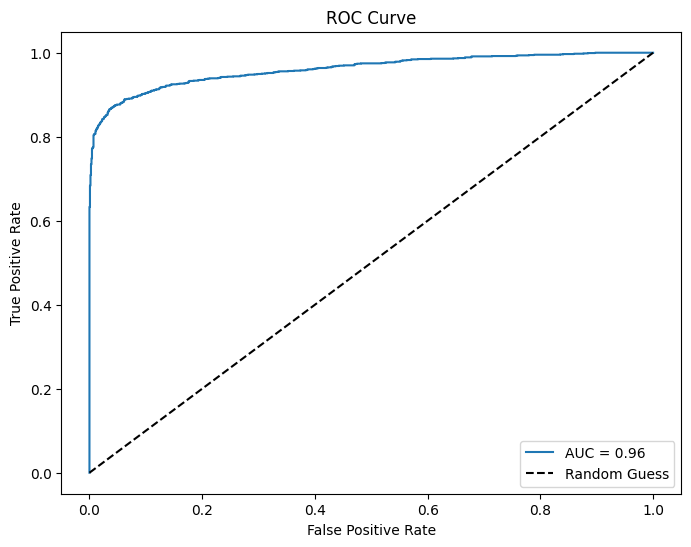

In [646]:
show_roc_curve(stacked_model_3, X_test_urgency, y_test_urgency)

In [655]:
# K-fold cross-validation using precision scoring
X = df[['text']]
y = df['label']
cross_validate_model(stacked_model_3, TfidfVectorizer(ngram_range=(1, 4)), X, y, cv=5, pipeline=stacked_model_3)

Cross-Validation <built-in method capitalize of str object at 0x1027bd0b0> Scores: [0.92851064 0.92468619 0.92320819 0.93277311 0.92821369]
Mean: 0.9275
Standard Deviation: 0.0033


array([0.92851064, 0.92468619, 0.92320819, 0.93277311, 0.92821369])